# Clustering by RNA

**Hypothesis**: Since the oHSC population can follow 2 distinct fates (normal hematopoiesis tree, ncMKP pathway), we hypothesize that oHSCs should form two transcriptional sub-clusters. One of these oHSC clusters would, for the most part, not express green fluorescent protein (GFP)- these ones being the oHSCs that differentiate to ncMKPs. If oMKPs are plotted as well, we would expect the ncMKP subset to cluster near the GFP- oHSC cluster, while the other HSC cluster that does have some GFP expression would be farther away from the cMKPs.

In [39]:
# setup: imports

import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from pathlib import Path
from typing import Any
import pyrootutils

# setup: path constants

ROOT = pyrootutils.setup_root(Path.cwd(), indicator='.git')
DATA = ROOT / "data"
FIGURES = ROOT / "figures"

poscablo_path = DATA / "rna_annotation_normalized.h5ad"
hsc_mkp_umap_path = FIGURES / "hsc_mkp_umap.png"
hsc_mkp_recomp_umap_path = FIGURES / "hsc_mkp_recomp_umap.png"
hsc_mkp_recomp_outgroup_umap_path = FIGURES / "hsc_mkp_recomp_outgroup_umap.png"

Load in the poscablo dataset and plot the pre-computed UMAP

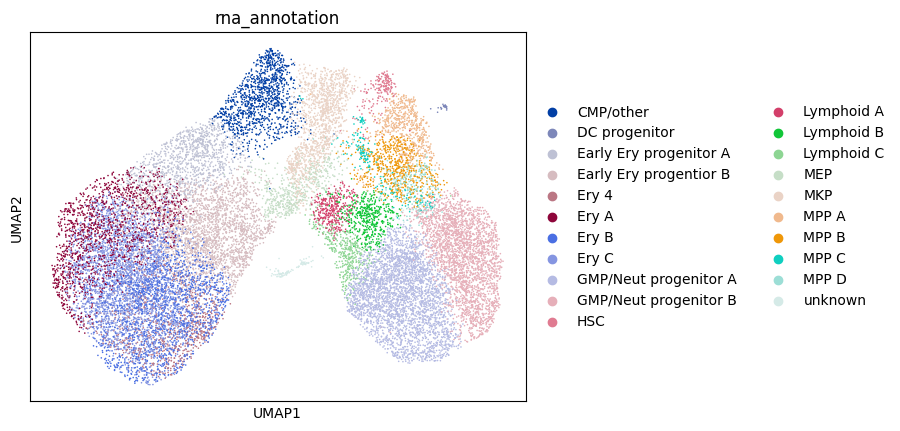

In [2]:
# load & plot data
poscablo = sc.read_h5ad(filename=poscablo_path)
sc.pl.umap(adata=poscablo, color=['rna_annotation'])

We're only concerned with old HSCs and old MKPs here, so we will do the following:
1. Filter for: (HSC or MKP) and (Old)
2. plot umap with cell labels and Egfp markers on old umap embedding
3. recompute neighborhood graph
4. recompute & plot umap with cell labels and Egfp markers

In [40]:
adata_hsc_mkp = poscablo[
    (poscablo.obs['rna_annotation'].isin({'HSC', 'MKP'}))
    &
    (poscablo.obs['Age'] == 'Old')
].copy()

adata_hsc_mkp.obs['annot_egfp'] = (
    adata_hsc_mkp.obs['Egfp_expression'].astype('str').replace({'positive': 'GFP+ ', 'negative': 'GFP- '})
    + 
    adata_hsc_mkp.obs['rna_annotation'].astype('str')
).astype('category')

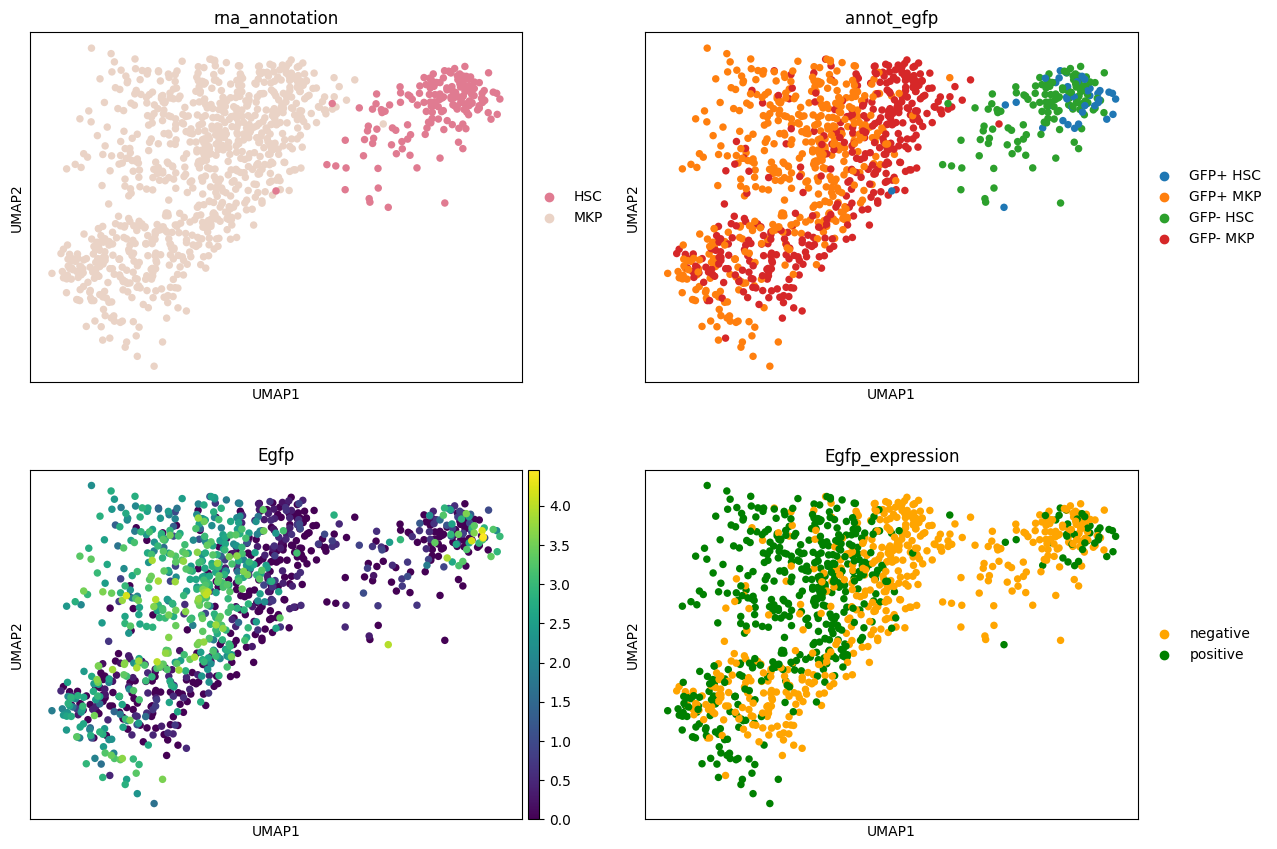

In [41]:
fig = sc.pl.umap(
    adata=adata_hsc_mkp, 
    color=['rna_annotation', 'annot_egfp', 'Egfp', 'Egfp_expression'],
    ncols=2,
    return_fig = True
)
assert isinstance(fig, Figure)
fig.savefig(hsc_mkp_umap_path)

Try recomputing w/ neighboring cell groups (MPP, MEP, CMP/other) and/or left field outgroups (Ery, GMP/Neut progenitor)

The above UMAPs visualize relationships generated from global UMAP coordinates and thus encode information from the rest of the not-pictured cells. To isolate the relationship between the old HSCs and MKPs and any subpopulations that may exist, the UMAP coordinates (and all prerequisite embeddings) need to be re-calculated with only the cells of interest.

In [ ]:
# recompute the embeddings

def recompute_umap(
        adata: sc.AnnData, 
        pca_kwargs: dict[str, Any] = {},
        neighbors_kwargs: dict[str, Any] = {},
        umap_kwargs: dict[str, Any] = {}
    ) -> sc.AnnData:
    """
    Recomputes 
    """
    uns_keep = {k: adata.uns[k] for k in adata.uns.keys() if (k.endswith('colors') or k.endswith('sizes'))}
    adata = sc.AnnData(X=adata.X, obs=adata.obs, var=adata.var, uns=uns_keep)  # type: ignore
    sc.pp.pca(data=adata, **pca_kwargs)
    sc.pp.neighbors(adata=adata, **neighbors_kwargs)
    sc.tl.umap(adata=adata, **umap_kwargs)
    return adata


adata_hsc_mkp = recompute_umap(
    adata=adata_hsc_mkp, 
    # pca_kwargs={}, 
    # neighbors_kwargs={'n_neighbors': 10},
    # umap_kwargs={}
)

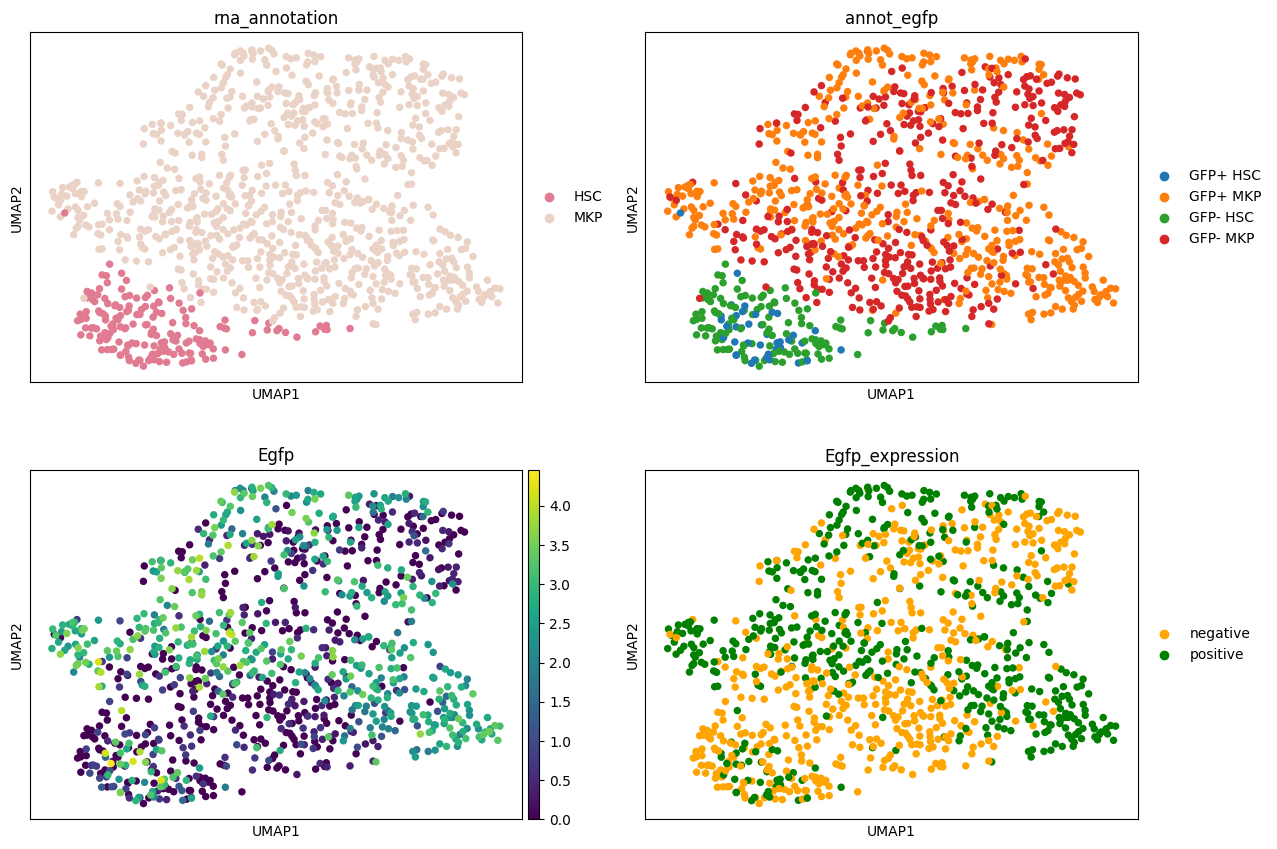

In [ ]:
# plot the embeddings

fig = sc.pl.umap(
    adata=adata_hsc_mkp, 
    color=['rna_annotation', 'annot_egfp', 'Egfp', 'Egfp_expression'],
    ncols=2,
    return_fig = True
)
assert isinstance(fig, Figure)
fig.savefig(hsc_mkp_recomp_umap_path)